# Análise do IBOVESPA com Previsão de Fechamento
Este notebook analisa os dados históricos do IBOVESPA e aplica técnicas de aprendizado de máquina para prever o fechamento futuro do índice com base em séries temporais. As técnicas incluem pré-processamento de dados, análise exploratória, treinamento de modelos de regressão e avaliação de desempenho.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt, ticker
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
)

### Definição de Funções de Avaliação
Aqui definimos funções para calcular as métricas de desempenho do modelo:

1. **MAE (Mean Absolute Error)**: Mede a média das diferenças absolutas entre as previsões e os valores reais. É útil para entender o erro médio em unidades da variável alvo.

2. **MSE (Mean Squared Error)**: Calcula a média dos quadrados das diferenças entre as previsões e os valores reais. Penaliza erros maiores mais fortemente que o MAE.

3. **MAPE (Mean Absolute Percentage Error)**: Expressa o erro médio como uma porcentagem do valor real. É útil para entender o erro relativo e comparar modelos entre diferentes escalas.


In [2]:
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    return mae, mse, mape


def print_metrics(metrics):
    mae, mse, mape = metrics
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"MAPE: {100 - mape: .2f} % ")

### Carregamento dos Dados do IBOVESPA - 10 anos
Carregando os dados históricos do IBOVESPA a partir de um arquivo CSV. Esses dados incluem informações sobre preços de abertura, fechamento, máxima, mínima, volume e variação percentual.

- **Data**: Data de cada registro.
- **Último**: Valor de fechamento do índice Ibovespa no dia.
- **Abertura**: Valor de abertura do índice no início do dia.
- **Máxima**: Valor máximo alcançado durante o dia.
- **Mínima**: Valor mínimo atingido no dia.
- **Vol.**: Volume de negociação.
- **Var%**: Variação percentual do valor.

In [3]:
df_ibovespa = pd.read_csv("data/ibovespa10a.csv", sep=",")
df_ibovespa.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,04.10.2024,131.791,131.672,131.936,131.156,"4,76M","0,09%"
1,03.10.2024,131.672,133.514,133.514,131.176,"9,82M","-1,38%"
2,02.10.2024,133.515,132.495,134.922,132.495,"9,40M","0,77%"
3,01.10.2024,132.495,131.817,133.405,131.817,"9,84M","0,51%"
4,30.09.2024,131.816,132.761,133.120,131.816,"9,13M","-0,69%"


### Tratamento da Coluna de Data

Convertendo a coluna 'Data' para o formato datetime e a configurando como índice do DataFrame, facilitando operações temporais futuras.

In [4]:
df_ibovespa['Data'] = pd.to_datetime(df_ibovespa.Data, format = "%d.%m.%Y")
df_ibovespa['DataFormatada'] = df_ibovespa['Data']
df_ibovespa.set_index('Data', inplace=True)
df_ibovespa.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%,DataFormatada
Data,,,,,,,
2024-10-04,131.791,131.672,131.936,131.156,"4,76M","0,09%",2024-10-04
2024-10-03,131.672,133.514,133.514,131.176,"9,82M","-1,38%",2024-10-03
2024-10-02,133.515,132.495,134.922,132.495,"9,40M","0,77%",2024-10-02
2024-10-01,132.495,131.817,133.405,131.817,"9,84M","0,51%",2024-10-01
2024-09-30,131.816,132.761,133.120,131.816,"9,13M","-0,69%",2024-09-30


### Transofrmando a coluna Vol. para valores numéricos

Convertendo a coluna 'Vol.' (volume) para valores numéricos, removendo os sufixos K (milhares), M (milhões), B (bilhões) e tratando as vírgulas

In [5]:
df_ibovespa['Vol.'] = df_ibovespa['Vol.'].str.replace('K', '0')
df_ibovespa['Vol.'] = df_ibovespa['Vol.'].str.replace('M', '0000')
df_ibovespa['Vol.'] = df_ibovespa['Vol.'].str.replace('B', '0000000')
df_ibovespa['Vol.'] = df_ibovespa['Vol.'].str.replace(',', '')
df_ibovespa['Vol.'] = pd.to_numeric(df_ibovespa['Vol.'])
df_ibovespa.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%,DataFormatada
Data,,,,,,,
2024-10-04,131.791,131.672,131.936,131.156,4760000.0,"0,09%",2024-10-04
2024-10-03,131.672,133.514,133.514,131.176,9820000.0,"-1,38%",2024-10-03
2024-10-02,133.515,132.495,134.922,132.495,9400000.0,"0,77%",2024-10-02
2024-10-01,132.495,131.817,133.405,131.817,9840000.0,"0,51%",2024-10-01
2024-09-30,131.816,132.761,133.120,131.816,9130000.0,"-0,69%",2024-09-30


### Ajustando a coluna Var%

Convertendo a coluna 'Var%' (variação percentual) para valores numéricos.


In [6]:
df_ibovespa['Var%'] = pd.to_numeric(df_ibovespa['Var%'].astype(str).apply(lambda x: x.split('%')[0].replace(',', '.')), errors='coerce')
df_ibovespa.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%,DataFormatada
Data,,,,,,,
2024-10-04,131.791,131.672,131.936,131.156,4760000.0,0.09,2024-10-04
2024-10-03,131.672,133.514,133.514,131.176,9820000.0,-1.38,2024-10-03
2024-10-02,133.515,132.495,134.922,132.495,9400000.0,0.77,2024-10-02
2024-10-01,132.495,131.817,133.405,131.817,9840000.0,0.51,2024-10-01
2024-09-30,131.816,132.761,133.120,131.816,9130000.0,-0.69,2024-09-30


### Ajustando o separador de milhar nas colunas Último, Abertura, Máxima e Mínima 

Corrigindo o formato das colunas 'Último', 'Abertura', 'Máxima' e 'Mínima', removendo o separador de milhar e convetendo para float

In [7]:
df_ibovespa['Último'] = df_ibovespa['Último'].apply(lambda x: f"{x:.3f}").str.replace('.', '').astype(float)
df_ibovespa['Abertura'] = df_ibovespa['Abertura'].apply(lambda x: f"{x:.3f}").str.replace('.', '').astype(float)
df_ibovespa['Máxima'] = df_ibovespa['Máxima'].apply(lambda x: f"{x:.3f}").str.replace('.', '').astype(float)
df_ibovespa['Mínima'] = df_ibovespa['Mínima'].apply(lambda x: f"{x:.3f}").str.replace('.', '').astype(float)
df_ibovespa.head(10)

,Último,Abertura,Máxima,Mínima,Vol.,Var%,DataFormatada
Data,,,,,,,
2024-10-04,131791.0,131672.0,131936.0,131156.0,4760000.0,0.09,2024-10-04
2024-10-03,131672.0,133514.0,133514.0,131176.0,9820000.0,-1.38,2024-10-03
2024-10-02,133515.0,132495.0,134922.0,132495.0,9400000.0,0.77,2024-10-02
2024-10-01,132495.0,131817.0,133405.0,131817.0,9840000.0,0.51,2024-10-01
2024-09-30,131816.0,132761.0,133120.0,131816.0,9130000.0,-0.69,2024-09-30
2024-09-27,132730.0,133010.0,133923.0,132628.0,9340000.0,-0.21,2024-09-27
2024-09-26,133010.0,131595.0,133313.0,131594.0,11620000.0,1.08,2024-09-26
2024-09-25,131586.0,132156.0,132982.0,131489.0,10530000.0,-0.43,2024-09-25
2024-09-24,132156.0,130570.0,133073.0,130570.0,9370000.0,1.22,2024-09-24


### Adicionando componentes temporais no Dataframe

Extraindo componentes temporais adicionais (ano, mês, semana, dia). Essas novas colunas serão úteis para capturar padrões sazonais e tendências.


In [8]:
df_ibovespa['Ano'] = df_ibovespa.index.year
df_ibovespa['Mes'] =  df_ibovespa.index.month
df_ibovespa['Semana'] =  df_ibovespa.index.day_of_week
df_ibovespa["Dia"] = df_ibovespa.index.day
df_ibovespa["DataFormatada"] = pd.to_datetime(df_ibovespa.index)
df_ibovespa.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2669 entries, 2024-10-04 to 2014-01-03
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Último         2669 non-null   float64       
 1   Abertura       2669 non-null   float64       
 2   Máxima         2669 non-null   float64       
 3   Mínima         2669 non-null   float64       
 4   Vol.           2668 non-null   float64       
 5   Var%           2669 non-null   float64       
 6   DataFormatada  2669 non-null   datetime64[ns]
 7   Ano            2669 non-null   int32         
 8   Mes            2669 non-null   int32         
 9   Semana         2669 non-null   int32         
 10  Dia            2669 non-null   int32         
dtypes: datetime64[ns](1), float64(6), int32(4)
memory usage: 208.5 KB


### Verificando valores nulos

In [9]:
print(df_ibovespa.isnull().sum())

Último           0
Abertura         0
Máxima           0
Mínima           0
Vol.             1
Var%             0
DataFormatada    0
Ano              0
Mes              0
Semana           0
Dia              0
dtype: int64


### Removendo valores nulos

In [10]:
df_ibov = df_ibovespa.dropna()
print(df_ibov.isnull().sum())

Último           0
Abertura         0
Máxima           0
Mínima           0
Vol.             0
Var%             0
DataFormatada    0
Ano              0
Mes              0
Semana           0
Dia              0
dtype: int64


### Analilsando estatísticas descritivas

Uma análise estatística descritiva fornece uma visão geral das características fundamentais do conjunto de dados e insights sobre a distribuição dos dados, incluindo médias, desvios padrão, valores mínimos e máximos para cada variável. Isso ajuda a identificar possíveis outliers e entender a escala e variabilidade dos dados.


In [11]:
df_ibov.describe().T

,count,mean,min,25%,50%,75%,max,std
Último,2668.0,87811.414168,37497.0,58993.5,94443.5,112299.25,137344.0,27905.747888
Abertura,2668.0,87781.637181,37501.0,58963.5,94411.0,112294.5,137349.0,27901.933627
Máxima,2668.0,88588.591079,38031.0,59395.75,95492.5,113401.25,137469.0,28039.39138
Mínima,2668.0,87001.263868,37046.0,58321.5,93552.0,111313.25,136664.0,27758.473179
Vol.,2668.0,7013640.625937,424320.0,3600000.0,5230000.0,10250000.0,26030000.0,4127341.857319
Var%,2668.0,0.048055,-14.78,-0.76,0.055,0.8825,13.91,1.527975
DataFormatada,2668,2019-05-26 05:53:31.394302720,2014-01-03 00:00:00,2016-09-13 18:00:00,2019-05-30 12:00:00,2022-02-04 18:00:00,2024-10-04 00:00:00,NaN
Ano,2668.0,2018.908171,2014.0,2016.0,2019.0,2022.0,2024.0,3.113555
Mes,2668.0,6.409295,1.0,3.0,6.0,9.0,12.0,3.383114
Semana,2668.0,1.997751,0.0,1.0,2.0,3.0,4.0,1.410495


## Visualização dos Dados

### Pontos de fechamento ao longo dos anos

Este gráfico nos permite visualizar a trajetória histórica do índice IBOVESPA, identificando tendências de longo prazo, períodos de volatilidade e possíveis pontos de inflexão no mercado.


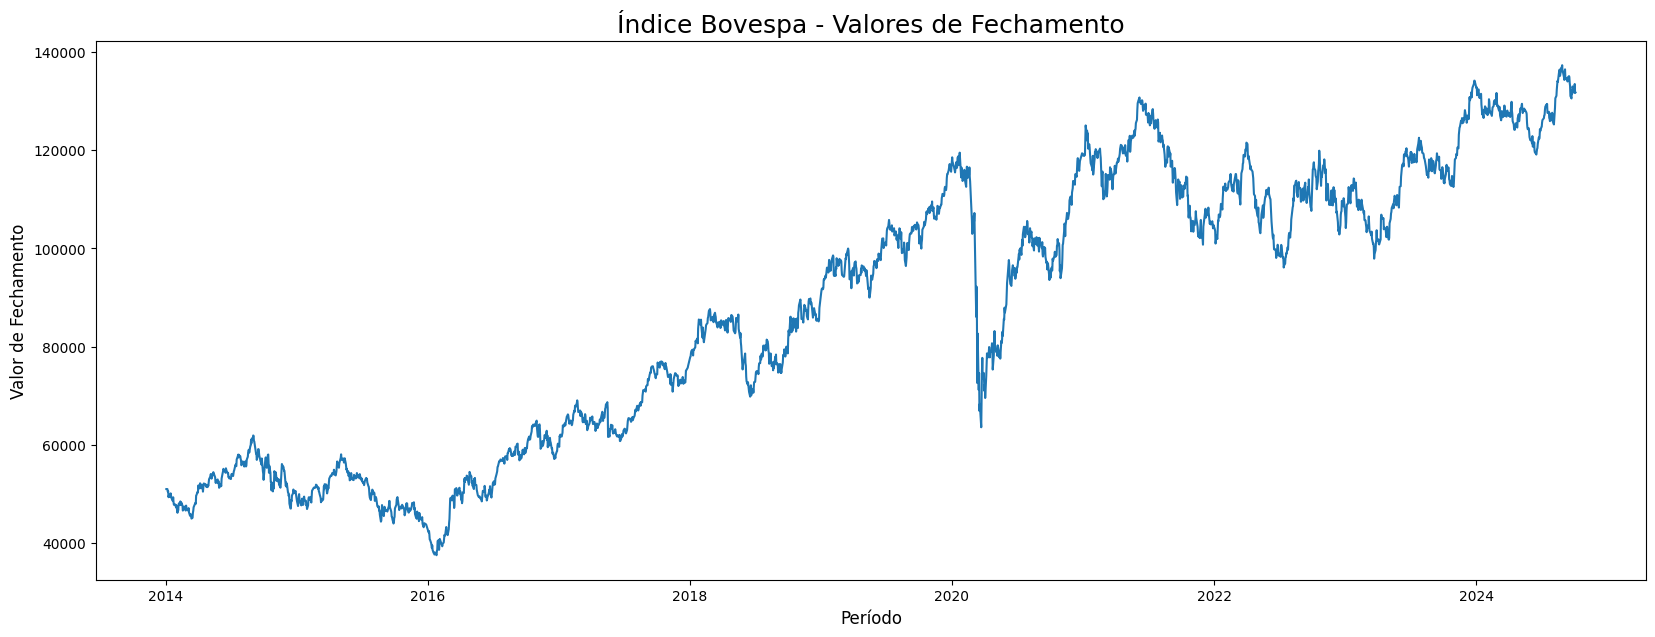

In [12]:
plt.figure(figsize = (20,7))

plt.plot(df_ibov.index, df_ibov.Último)
plt.title('Índice Bovespa - Valores de Fechamento', fontsize=18)
plt.xlabel('Período', fontsize=12)
plt.ylabel('Valor de Fechamento', fontsize=12)

plt.show()

### Decomposição Sazonal

A decomposição sazonal nos permite separar a série temporal em componentes de tendência, sazonalidade e resíduo. Isso nos ajuda a entender melhor os padrões do índice IBOVESPA.



<Axes: title={'center': 'Decomposição Sazonal Anual'}, xlabel='Data'>

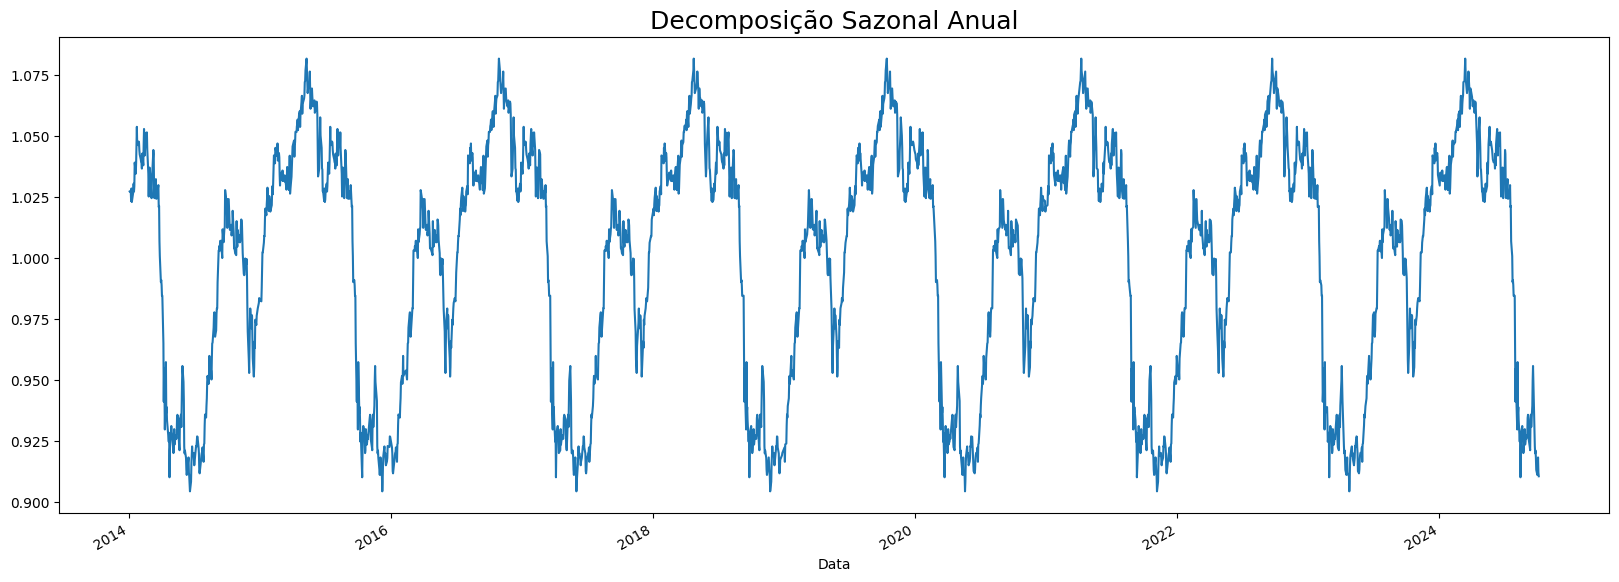

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

plt.title('Decomposição Sazonal Anual', fontsize=18)

result = seasonal_decompose(df_ibov["Último"], model="multiplicative", period=365)
result.seasonal.plot(figsize=(20, 7))

<Axes: title={'center': 'Decomposição Sazonal Mensal'}, xlabel='Data'>

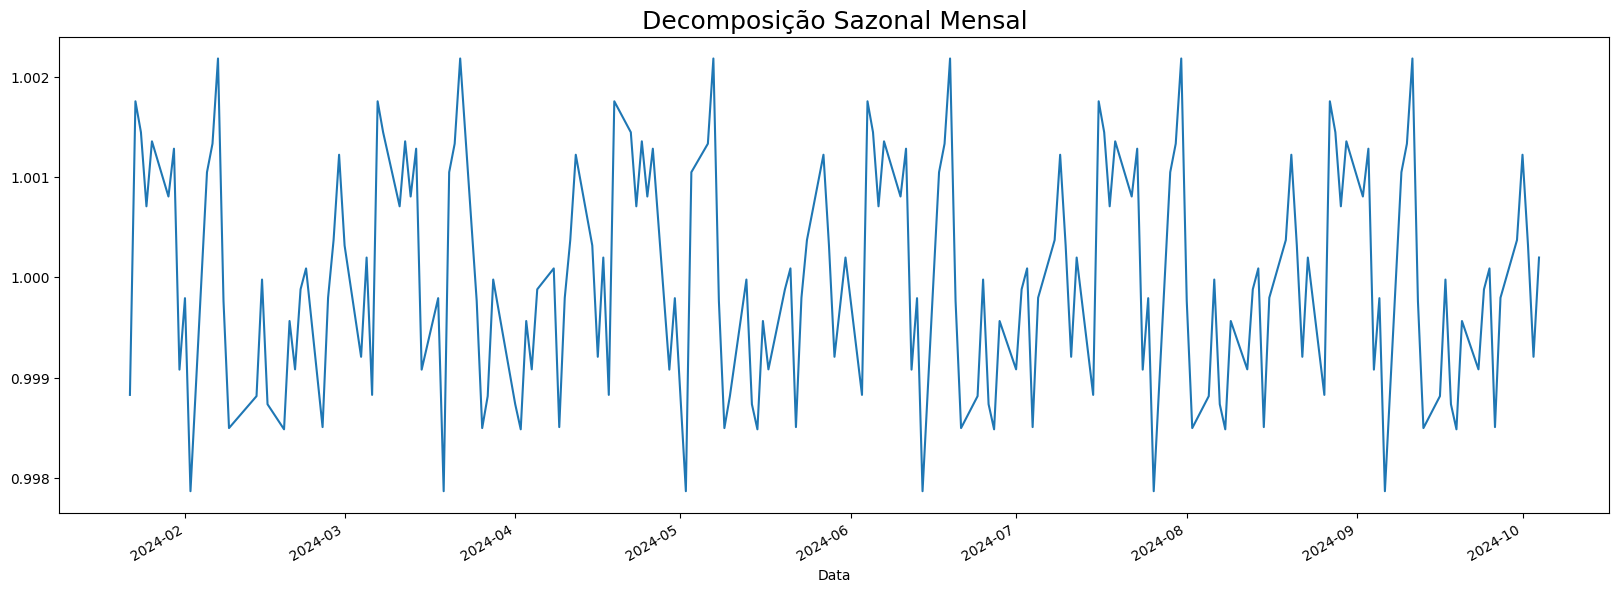

In [14]:
plt.title('Decomposição Sazonal Mensal', fontsize=18)
result = seasonal_decompose(df_ibov["Último"], model="multiplicative", period=30)
result.seasonal.iloc[:180].plot(figsize=(20, 7))

- **Tendência:** Mostra a direção geral de longo prazo.
- **Sazonalidade:** Revela padrões cíclicos que se repetem anualmente.
- **Resíduo:** Representa as flutuações irregulares que não são explicadas pela tendência ou sazonalidade.

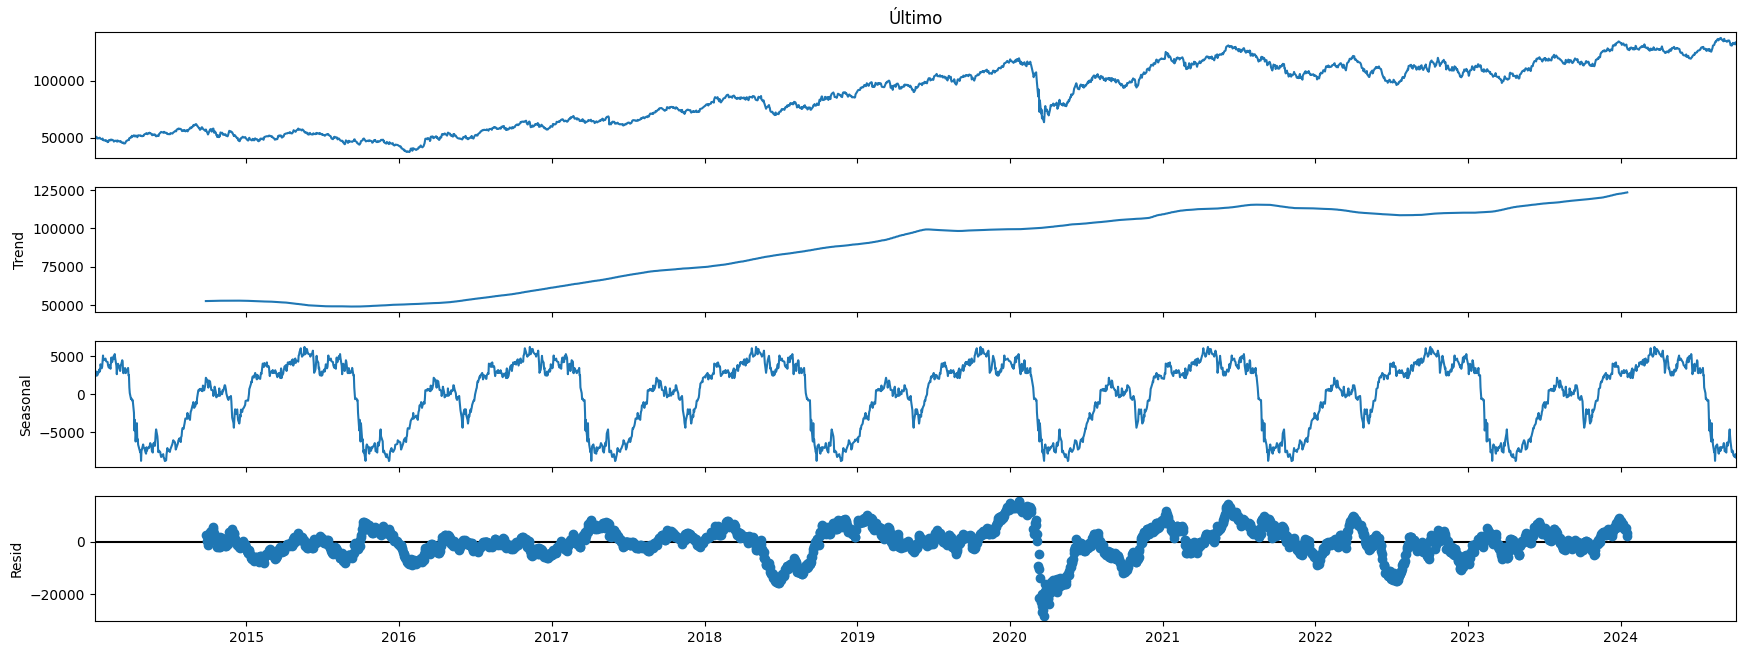

In [15]:
result = seasonal_decompose(df_ibov["Último"].sort_index(), model="additive", period=365)
fig = result.plot()
fig.set_size_inches(20, 7)


### Análise de Autocorrelação (ACF) e Autocorrelação Parcial (PACF)

As funções de autocorrelação (ACF) e autocorrelação parcial (PACF) são ferramentas para identificar padrões de dependência temporal. Elas nos ajudam a determinar os parâmetros adequados para modelos de séries temporais.


In [16]:
from statsmodels.graphics.tsaplots import plot_acf as _plot_acf
import statsmodels.api as sm
import numpy as np

def plot_acf(data, lags=365, title="Autocorrelação da Série Temporal"):

    fig, ax = plt.subplots(figsize=(15, 5))
    # Get the ACF values and confidence intervals
    _plot_acf(data, lags=lags, ax=ax, alpha=0.05)
    ax.set_title(title)
    ax.set_xlabel("Lags")
    ax.set_ylabel("Autocorrelação")
    fig.set_tight_layout(True)

    acf_x = sm.tsa.acf(data, alpha=0.05, nlags=lags)
    acf, ci = acf_x[:2]
    intercept_point = np.where(abs(acf) < (ci[:, 1] - acf))
    if intercept_point[0].size > 0:
        print(
            f"The ACF coefficients intercept the threshold at lag {intercept_point[0][0]}"
        )
    else:
        print("The ACF coefficients do not intercept the threshold")

- O gráfico ACF mostra a correlação entre uma série temporal e seus valores defasados (lags).
- Barras que ultrapassam as linhas pontilhadas (intervalo de confiança) são estatisticamente significativas.
- Um declínio lento na ACF pode indicar uma série não estacionária ou com forte persistência.
- Padrões cíclicos na ACF sugerem sazonalidade nos dados.

The ACF coefficients intercept the threshold at lag 244


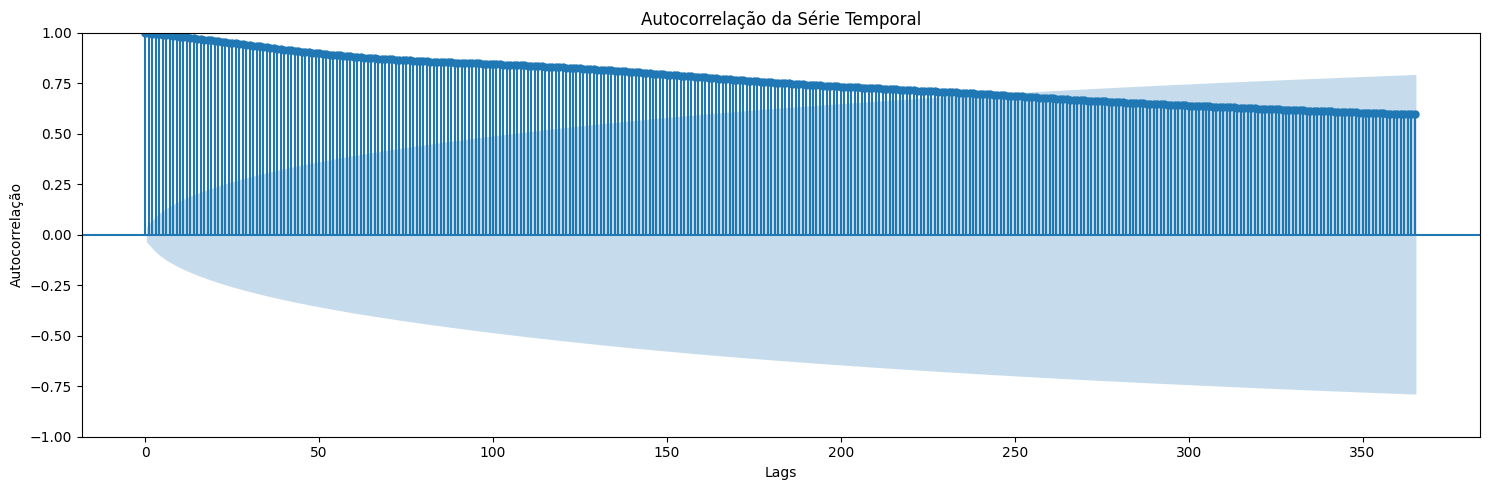

In [17]:
plot_acf(df_ibov["Último"])

In [18]:
from statsmodels.graphics.tsaplots import plot_acf as _plot_pacf

def plot_pacf(data, lags=30, title="Autocorrelação Parcial da Série Temporal"):

    fig, ax = plt.subplots(figsize=(15, 5))
    # Get the ACF values and confidence intervals
    _plot_pacf(data, lags=lags, ax=ax, alpha=0.05)
    ax.set_title(title)
    ax.set_xlabel("Lags")
    ax.set_ylabel("Autocorrelação Parcial")
    fig.set_tight_layout(True)

    acf_x = sm.tsa.pacf(data, alpha=0.05, nlags=lags)
    acf, ci = acf_x[:2]
    intercept_point = np.where(abs(acf) < (ci[:, 1] - acf))
    if intercept_point[0].size > 0:
        print(
            f"The PACF coefficients intercept the threshold at lag {intercept_point[0][0]}"
        )
    else:
        print("The PACF coefficients do not intercept the threshold")

- O PACF mostra a correlação parcial entre uma série temporal e seus lags, controlando para os lags intermediários.
- Ajuda a identificar a ordem do termo autoregressivo (AR) em modelos ARIMA.
- Lags significativos no PACF indicam a importância desses lags específicos na previsão do valor atual.


The PACF coefficients intercept the threshold at lag 4


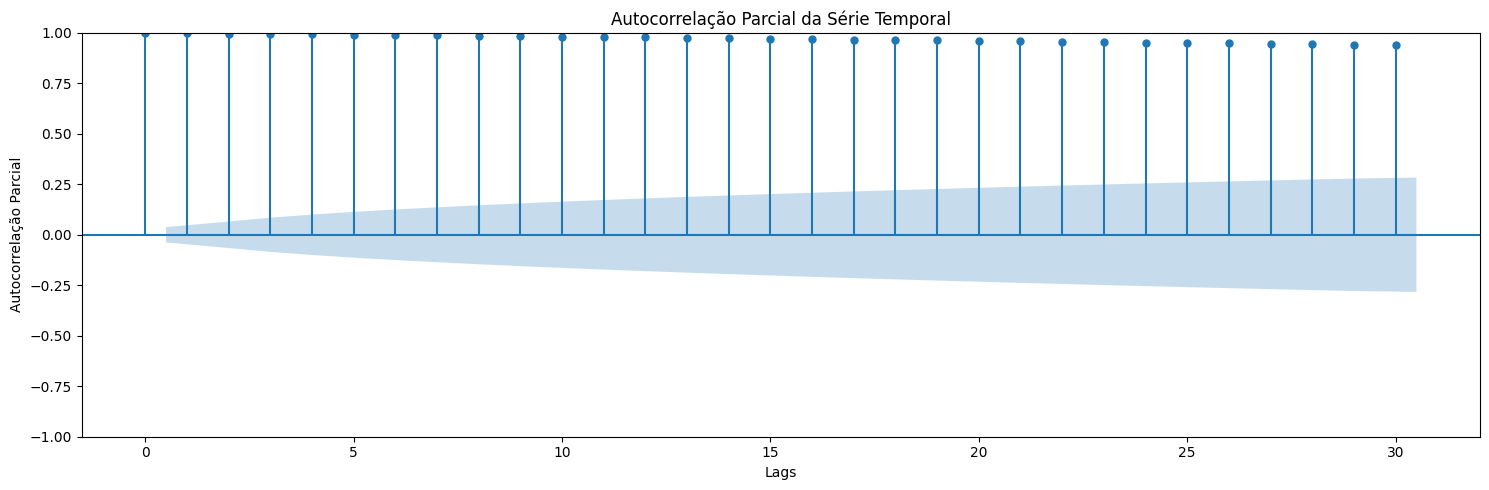

In [19]:
plot_pacf(df_ibov["Último"])

### Teste de Estacionariedade

A estacionariedade é uma propriedade importante para muitos modelos de séries temporais. Foi utilizado o teste Augmented Dickey-Fuller (ADF) para verificar se a série do IBOVESPA é estacionária.

- O teste ADF verifica a hipótese nula de que uma série temporal tem uma raiz unitária (não é estacionária).
- Um p-valor menor que 0.05 nos permite rejeitar a hipótese nula e concluir que a série é estacionária.
- No nosso caso, a série não é estacionária, o que é comum em dados financeiros.


In [20]:
adf_result = sm.tsa.adfuller(df_ibov["Último"])
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print(f"Critical Values: {adf_result[4]}")

if adf_result[1] < 0.05:
    print("A série temporal é estacionária")
else:
    print("A série temporal não é estacionária")

ADF Statistic: -1.3776840543749849
p-value: 0.5929266802519471
Critical Values: {'1%': -3.4328107600573845, '5%': -2.8626271794692513, '10%': -2.567348742862796}
A série temporal não é estacionária


Como a série não é estacionária, aplicamos a diferenciação para torná-la estacionária. Este é um passo comum no pré-processamento de séries temporais financeiras. O gráfico abaixo mostra a série diferenciada.

<Axes: xlabel='Data'>

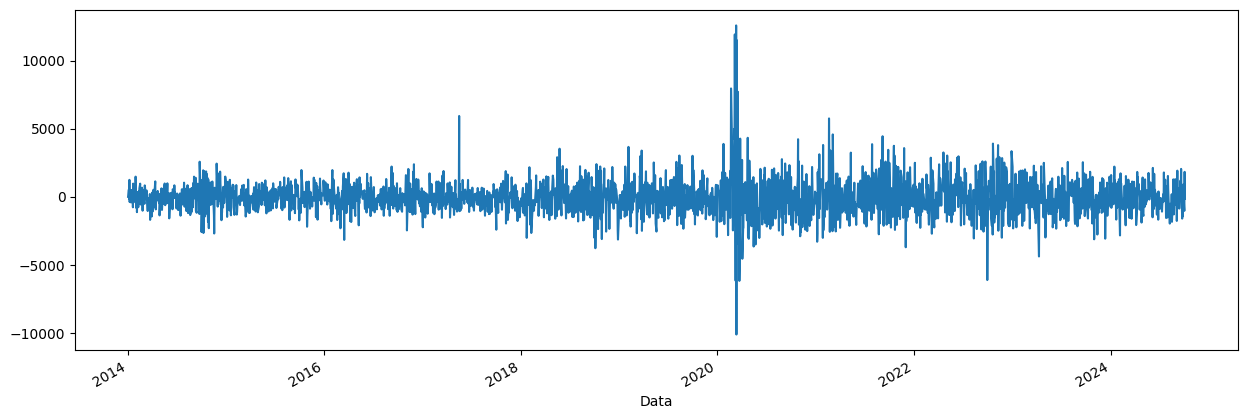

In [21]:
df_ibov["Último"].diff().plot(figsize=(15, 5))

Após a diferenciação, o teste ADF indica que a série se tornou estacionária

In [22]:
adf_result = sm.tsa.adfuller(df_ibov["Último"].diff().dropna())
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print(f"Critical Values: {adf_result[4]}")
if adf_result[1] < 0.05:
  print("A série temporal é estacionária")
else:
  print("A série temporal não é estacionária")

ADF Statistic: -18.066140430464113
p-value: 2.6126261419437592e-30
Critical Values: {'1%': -3.4328107600573845, '5%': -2.8626271794692513, '10%': -2.567348742862796}
A série temporal é estacionária


### Identificação dos Parâmetros do Modelo ARIMA

Utilizando as funções ACF e PACF para identificar os parâmetros p, d e q do modelo ARIMA (AutoRegressive Integrated Moving Average).

- p (ordem autoregressiva): Número de lags da variável dependente a serem usados como preditores.
- d (grau de diferenciação): Número de vezes que a série precisa ser diferenciada para se tornar estacionária.
- q (ordem de média móvel): Tamanho da janela da média móvel.

In [23]:
acf_x = sm.tsa.acf(df_ibov["Último"], alpha=0.05, nlags=365)
acf, ci = acf_x[:2]
# identificação do q pelo ponto de interceptação ao 95% com o acf
q = np.where(abs(acf) < (ci[:, 1] - acf))[0][0]

pacf_x = sm.tsa.pacf(df_ibov["Último"], alpha=0.05, nlags=30)
pacf, ci = pacf_x[:2]
# identificação do p pelo ponto de interceptação ao 95% com o pacf
p = np.where(abs(pacf) < (ci[:, 1] - pacf))[0][0]

d = 1  # apenas 1 diferenciação foi necessária para tornar a série estacionária

# parâmetros do modelo ARIMA
p, q, d

(4, 244, 1)

## Modelagem e Previsão

Nesta seção, implementamos e comparamos diferentes modelos de previsão para o índice IBOVESPA. A comparação nos ajudará a entender qual abordagem é mais adequada para nossos dados.

### Auto ARIMA

Encontrando os melhores parâmetros para o modelo ARIMA

- O modelo escolhe automaticamente os melhores parâmetros ARIMA baseado em critérios de informação (como AIC ou BIC).
- Considera também componentes sazonais (m=12 para sazonalidade anual).
- Compara este resultado com os parâmetros que identificamos manualmente para ver se há discrepâncias significativas.

In [24]:
import pmdarima as pm

model = pm.auto_arima(
    df_ibov["Último"],
    seasonal=True,
    m=12,
    stepwise=True,
)

# Summary of the model's detected parameters
print(model.summary())

# Detected seasonal order
seasonal_order = model.seasonal_order
print(f"Detected Seasonal Order: {seasonal_order}")

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2668
Model:               SARIMAX(2, 1, 0)   Log Likelihood              -22866.028
Date:                Mon, 14 Oct 2024   AIC                          45738.055
Time:                        17:28:35   BIC                          45755.722
Sample:                             0   HQIC                         45744.448
                               - 2668                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0336      0.006     -6.014      0.000      -0.045      -0.023
ar.L2          0.0258      0.008      3.139      0.002       0.010       0.042
sigma2      1.633e+06   2.05e+04     79.646      0.0

### Preparação dos Dados para Modelagem

Dividindo os dados em conjuntos de treino e teste.

- Usamos os últimos 7 dias como conjunto de teste.
- As features incluem componentes temporais (Ano, Mês, Semana, Dia) e o preço de abertura.
- Nossa variável alvo (TARGET) é o preço de fechamento ("Último").


In [25]:
# Dividindo em treino e teste

train_size = df_ibov.shape[0] - 7
train, test = df_ibov[:train_size], df_ibov[train_size:]

FEATURES = ["Ano", "Mes", "Semana", "Dia", "Abertura"]
TARGET = "Último"

### Modelo XGBoost

XGBoost (eXtreme Gradient Boosting) é um algoritmo de aprendizado de máquina baseado em árvores de decisão que utiliza o princípio de boosting. É conhecido por sua eficácia em problemas de regressão e classificação.

In [26]:
import xgboost as xgb

# Modelo XGBoost
X_train, y_train = train[FEATURES], train[TARGET]
X_test, y_test = test[FEATURES], test[TARGET]

reg = xgb.XGBRegressor(objective="reg:squarederror")
reg.fit(X_train, y_train)

# Avaliação XGBoost
preds = reg.predict(X_test)
metrics_xgb = calculate_metrics(y_test, preds)
print("XGBoost Metrics:")
print_metrics(metrics_xgb)

XGBoost Metrics:
MAE: 933.3560267857143
MSE: 1249683.5399300712
MAPE:  98.14 % 


### Modelo Prophet

Prophet é uma biblioteca de previsão de séries temporais desenvolvida pelo Facebook. É particularmente eficaz em dados com forte sazonalidade e tendências não lineares.


In [41]:
from prophet import Prophet

# Modelo Prophet
train_prophet = train.rename(columns={"DataFormatada": "ds", "Último": "y"})
test_prophet = test.rename(columns={"DataFormatada": "ds", "Último": "y"})

model = Prophet(daily_seasonality=True)
model.add_regressor("Abertura")
model.fit(train_prophet)

future = model.make_future_dataframe(periods=len(test))
future["Abertura"] = pd.concat([train["Abertura"], test["Abertura"]], ignore_index=True)
forecast = model.predict(future)

ppreds = forecast[["ds", "yhat"]].tail(len(test))
ppreds = ppreds.set_index("ds")
y_test = test_prophet.set_index("ds")["y"]

metrics_pr = calculate_metrics(y_test, ppreds["yhat"])
print("Prophet Metrics:")
print_metrics(metrics_pr)

14:15:39 - cmdstanpy - INFO - Chain [1] start processing
14:15:41 - cmdstanpy - INFO - Chain [1] done processing


Prophet Metrics:
MAE: 2412.903365559187
MSE: 6356986.436299878
MAPE:  95.18 % 


In [28]:
p, d, q

(4, 1, 244)

### Modelo SARIMAX
SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors) é uma extensão do modelo ARIMA que incorpora sazonalidade e variáveis exógenas.


In [43]:
# Modelo SARIMAX
exog_train = train[["Abertura"]]
exog_test = test[["Abertura"]]

model = sm.tsa.statespace.SARIMAX(
    train["Último"],
    exog=exog_train,
    order=(
        p,
        d,
        1,
    ),  # q muito grande faz com que o modelo fique muito complexo e lento
    seasonal_order=(0, 0, 0, 12),
)
results = model.fit()

spreds = results.get_forecast(steps=len(test), exog=exog_test).predicted_mean

metrics_sarimax = calculate_metrics(test["Último"], spreds)
print("SARIMAX Metrics:")
print_metrics(metrics_sarimax)

/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.57026D+00    |proj g|=  6.38152D-02

At iterate    5    f=  8.56942D+00    |proj g|=  4.52757D-04

At iterate   10    f=  8.56940D+00    |proj g|=  7.79689D-03

At iterate   15    f=  8.56898D+00    |proj g|=  8.99690D-03

At iterate   20    f=  8.56886D+00    |proj g|=  4.30649D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     23     25      1     0     0   6.289D-06   8.569D+00
  F =   8.5688618476173755     

CONVERG

/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


## Comparação dos Modelos

Comparando o desempenho dos diferentes modelos utilizados.


In [32]:
df = pd.DataFrame(
    [metrics_xgb, metrics_pr, metrics_sarimax],
    columns=["MAE", "MSE", "MAPE"],
    index=["XGBoost", "Prophet", "SARIMAX"],
)

df["MAPE"] = df["MAPE"].apply(lambda x: f"{100 - x: .2f}")

df.sort_values(by="MAPE", ascending=True)

,MAE,MSE,MAPE
Prophet,2412.903366,6.356986e+06,95.18
XGBoost,933.356027,1.249684e+06,98.14
SARIMAX,731.154133,7.974837e+05,98.56
